# Modelling and Evaluation

## import dependencies

In [70]:
import numpy as np
import pandas as pd
import tensorflow as tf
# import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
# from PIL import Image

import matplotlib.pyplot as plt
import os
# import PIL
# import shutil
# import random
# import glob
# import itertools

## set up directories

In [71]:
os.chdir(os.path.expanduser('~'))
os.chdir('Desktop/skin')

train_dir = 'inputs/work/train'
test_dir = 'inputs/work/test'
val_dir = 'inputs/work/validate'

## Data Preprocessing

In [72]:
image_size = (224, 224)
batch_size = 32
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

# datagen = ImageDataGenerator(
#     zoom_range = 0.3, 
#     rotation_range = 90, 
#     horizontal_flip = True, 
#     vertical_flip = True
# )

# datagen = ImageDataGenerator(
#     rotation_range=20, 
#     width_shift_range=0.10,  
#     height_shift_range=0.10, 
#     shear_range=0.1, 
#     zoom_range=0.1, 
#     horizontal_flip=True, 
#     vertical_flip=True, 
#     fill_mode='nearest',
#     rescale=1./255
# )

train_batches = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=classes
)

test_batches = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=classes
)

valid_batches = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=classes
)

Found 1229 images belonging to 7 classes.


Found 351 images belonging to 7 classes.
Found 177 images belonging to 7 classes.


## Build CNN and Train
* This step can be skipped if a model has been trained previously.

In [73]:
model = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=7, activation='softmax'),
])

model.compile(optimizer= Adam(learning_rate = 0.001), 
              loss= 'categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │     1,404,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,424,455 (5.43 MB)

 Trainable params: 1,424,391 (5.43 MB)

 Non-trainable params: 64 (256.00 B)

Load previous model if it exists

In [74]:
if os.path.exists('outputs/model.keras'):
    model = load_model('outputs/model.keras')
    print('Previous Model loaded')
else: 
    print('Training new model')

Previous Model loaded


Training step, this is time consuming. The trained model is saved, so predictions can be tested without retraining the model and training can be resumed if desired. 

In [75]:
model.fit(
    x=train_batches, 
    validation_data=valid_batches,
    # callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    epochs=50, 
    verbose=2)
model.save('outputs/model.keras')

Epoch 1/50


/home/pxp/anaconda3/envs/ten3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 - 40s - 1s/step - accuracy: 0.5094 - loss: 1.3867 - val_accuracy: 0.2994 - val_loss: 5.4689
Epoch 2/50
39/39 - 39s - 998ms/step - accuracy: 0.4923 - loss: 1.4359 - val_accuracy: 0.4124 - val_loss: 3.1163
Epoch 3/50
39/39 - 39s - 989ms/step - accuracy: 0.5028 - loss: 1.4004 - val_accuracy: 0.2825 - val_loss: 6.7951
Epoch 4/50
39/39 - 39s - 994ms/step - accuracy: 0.5216 - loss: 1.3129 - val_accuracy: 0.3672 - val_loss: 2.9746
Epoch 5/50
39/39 - 39s - 1s/step - accuracy: 0.5232 - loss: 1.3129 - val_accuracy: 0.3898 - val_loss: 3.2074
Epoch 6/50
39/39 - 39s - 1s/step - accuracy: 0.5313 - loss: 1.2735 - val_accuracy: 0.3955 - val_loss: 4.0645
Epoch 7/50
39/39 - 39s - 995ms/step - accuracy: 0.5240 - loss: 1.2521 - val_accuracy: 0.4633 - val_loss: 1.9780
Epoch 8/50
39/39 - 39s - 999ms/step - accuracy: 0.5443 - loss: 1.3062 - val_accuracy: 0.4746 - val_loss: 1.7339
Epoch 9/50
39/39 - 38s - 977ms/step - accuracy: 0.5403 - loss: 1.3166 - val_accuracy: 0.4915 - val_loss: 2.1004
Epoch 10/50


### Model Evaluation

This step requires training the model, or there will be no history data.  

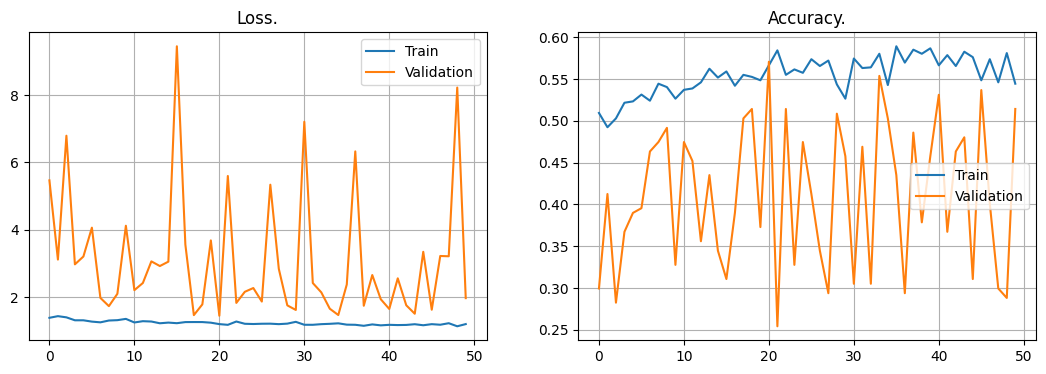

In [76]:
metrics = model.history.history

train_loss = metrics["loss"]
train_accuracy = metrics["accuracy"]

val_loss = metrics["val_loss"]
val_accuracy = metrics["val_accuracy"]

plt.figure(figsize = (13,4))
plt.subplot(1,2,1)
plt.title("Loss.")
plt.plot(train_loss, label = "Train");
plt.plot(val_loss, label = "Validation");
plt.grid(True)
plt.legend(loc = "best");

plt.subplot(1,2,2)
plt.title("Accuracy.")
plt.plot(train_accuracy, label = "Train");
plt.plot(val_accuracy, label = "Validation");
plt.grid(True)
plt.legend(loc = "best");

## Model Prediction

In [77]:
# model = load_model('outputs/model.keras')

In [78]:
batch = test_batches
predictions = model.predict(x=batch, verbose=0)
true_labels = batch.classes
predicted_labels = np.argmax(predictions, axis=1)
class_names = {v: k for k, v in batch.class_indices.items()}
report = classification_report(true_labels, predicted_labels, target_names=class_names.values())
print(report)

              precision    recall  f1-score   support

       akiec       0.14      0.13      0.14        60
         bcc       0.10      0.07      0.08        60
         bkl       0.11      0.17      0.13        60
          df       0.00      0.00      0.00        23
         mel       0.24      0.38      0.30        60
          nv       0.16      0.10      0.12        60
        vasc       0.07      0.07      0.07        28

    accuracy                           0.15       351
   macro avg       0.12      0.13      0.12       351
weighted avg       0.13      0.15      0.14       351



/home/pxp/anaconda3/envs/ten3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pxp/anaconda3/envs/ten3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pxp/anaconda3/envs/ten3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

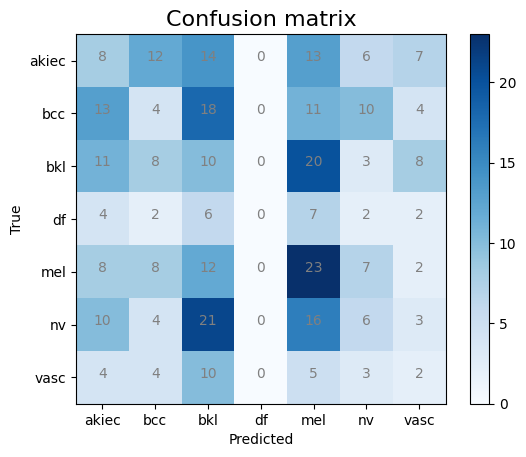

In [79]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
# classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix', fontsize=16)
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel('True')
plt.xlabel('Predicted')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="gray")